In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
input_data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [8]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'maize flour' 

In [9]:
location_ids = pd.read_csv(input_data_path)
location_ids = location_ids[(location_ids.vehicle==vehicle)].location_id.unique().tolist()
location_ids

[201, 202, 205, 171, 180, 184, 196, 190, 189]

In [10]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [11]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
201    1.712028
202    1.712028
205    1.712028
171    1.712028
180    1.712028
184    1.712028
196    1.712028
190    1.712028
189    1.712028
dtype: float64

In [12]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [13]:
data = create_marginal_uncertainty(data)

In [14]:
data.head()

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
10,201,Burkina Faso,NaN,maize flour,percent of population eating vehicle,na,26.610000,12.497238,40.722762
11,201,Burkina Faso,NaN,maize flour,percent of population eating industrially prod...,na,0.000020,0.000010,0.000030
12,201,Burkina Faso,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000020,0.000010,0.000030
26,202,Cameroon,NaN,maize flour,percent of population eating vehicle,na,47.299581,25.263375,69.335787
27,202,Cameroon,NaN,maize flour,percent of population eating industrially prod...,na,9.278995,4.956042,13.601947


In [15]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [16]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [17]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [18]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [19]:
paf_ntds_nofort.mean(axis=1)

location_id
201    0.411496
202    0.396286
205    0.350503
171    0.411496
180    0.411496
184    0.368265
196    0.227417
190    0.395693
189    0.405472
dtype: float64

In [20]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [21]:
pif_ntds_nofort.head()

draw_0  draw_1  \
location_id year_id age_group_id sex_id coverage_level                   
171         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_2  draw_3  \
location_id year_id age_group_id sex_id coverage_level                   
171         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_4  draw_5  \
location_id year_id age_group_id sex_id coverage_level                   
171         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_6  draw_7  \
location_id year_id age_group_id sex_id coverage_level                   
171         2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_8  draw_9  ...  \
location_id year_id age_group_id sex_id coverage_level                  ...   
171         2022    2            1      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   
                                        0.8                0.0     0.0  ...   
                                 2      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   

                                                        draw_990  draw_991  \
location_id year_id age_group_id sex_id coverage_level                       
171         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_992  draw_993  \
location_id year_id age_group_id sex_id coverage_level                       
171         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_994  draw_995  \
location_id year_id age_group_id sex_id coverage_level                       
171         2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                    

In [22]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [23]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [24]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [25]:
dalys_averted_u5.head()

draw_0      draw_1       draw_2  \
location_id year_id coverage_level                                         
171         2022    0.2                0.000000    0.000000     0.000000   
                    0.5                0.000000    0.000000     0.000000   
                    0.8                0.000000    0.000000     0.000000   
            2023    0.2              721.556337  375.430453   449.049408   
                    0.5             1803.890842  938.576133  1122.623520   

                                         draw_3      draw_4      draw_5  \
location_id year_id coverage_level                                        
171         2022    0.2                0.000000    0.000000    0.000000   
                    0.5                0.000000    0.000000    0.000000   
                    0.8                0.000000    0.000000    0.000000   
            2023    0.2              720.172378  317.230839  385.868529   
                    0.5             1800.430944  793.077097  964.671323   

                                         draw_6      draw_7      draw_8  \
location_id year_id coverage_level                                        
171         2022    0.2                0.000000    0.000000    0.000000   
                    0.5                0.000000    0.000000    0.000000   
                    0.8                0.000000    0.000000    0.000000   
            2023    0.2              558.244210  276.374647  379.261608   
                    0.5             1395.610525  690.936617  948.154020   

                                        draw_9  ...     draw_990    draw_991  \
location_id year_id coverage_level              ...                            
171         2022    0.2               0.000000  ...     0.000000    0.000000   
                    0.5               0.000000  ...     0.000000    0.000000   
                    0.8               0.000000  ...     0.000000    0.000000   
            2023    0.2             351.987965  ...   683.590250  353.851778   
                    0.5             879.969913  ...  1708.975626  884.629444   

                                       draw_992     draw_993    draw_994  \
location_id year_id coverage_level                                         
171         2022    0.2                0.000000     0.000000    0.000000   
                    0.5                0.000000     0.000000    0.000000   
                    0.8                0.000000     0.000000    0.000000   
            2023    0.2              681.447918   460.347716  275.860509   
                    0.5             1703.619796  1150.869289  689.651273   

                                       draw_995    draw_996     draw_997  \
location_id year_id coverage_level                                         
171         2022    0.2                0.000000    0.000000     0.000000   
                    0.5                0.000000    0.000000     0.000000   
                    0.8                0.000000    0.000000     0.000000   
            2023    0.2              706.999965  387.218358   544.406487   
                    0.5             1767.499912  968.045896  1361.016219   

                                      draw_998     draw_999  
location_id year_id coverage_level                           
171         2022    0.2               0.000000     0.000000  
                    0.5               0.000000     0.000000  
                    0.8               0.000000     0.000000  
            2023    0.2             330.126833   486.060191  
                    0.5             825.317083  1215.150478  

[5 rows x 1000 columns]

In [26]:
dalys_averted_path = '/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_maize_flour_dalys_averted_folic_acid_03_29_2021.csv.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [27]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [28]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [29]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,171,2022,0.2,0.000000,0.000000,0.000000,1.362947e+07,0.000000,0.000000,0.000000
1,171,2022,0.5,0.000000,0.000000,0.000000,1.362947e+07,0.000000,0.000000,0.000000
2,171,2022,0.8,0.000000,0.000000,0.000000,1.362947e+07,0.000000,0.000000,0.000000
3,171,2023,0.2,379.864992,166.112523,712.210937,1.362947e+07,2.787087,1.218775,5.225524
4,171,2023,0.5,949.662481,415.281308,1780.527341,1.362947e+07,6.967716,3.046938,13.063809


# viz results

In [30]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

In [31]:
{i:j for (i,j) in zip(data.location_id,data.location_name)}

{201: 'Burkina Faso',
 202: 'Cameroon',
 205: "Côte d'Ivoire",
 171: 'Democratic Republic of the Congo',
 180: 'Kenya',
 184: 'Mozambique',
 196: 'South Africa',
 190: 'Uganda',
 189: 'United Republic of Tanzania'}

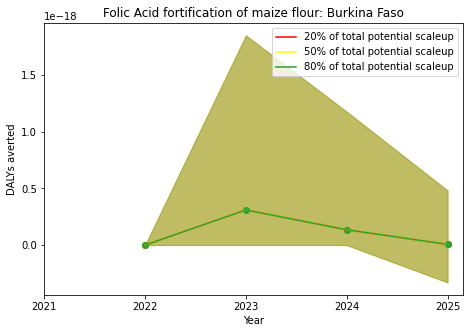

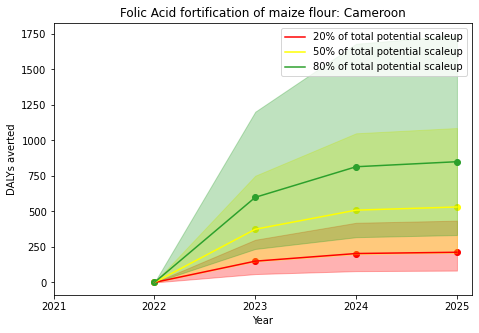

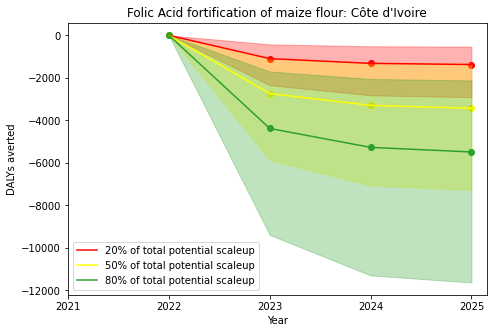

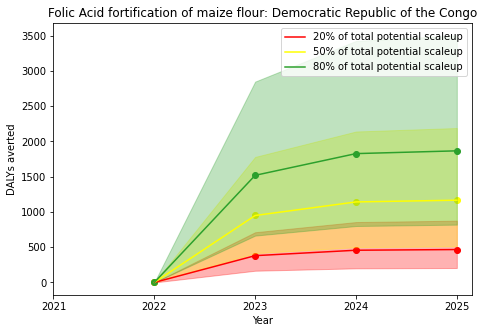

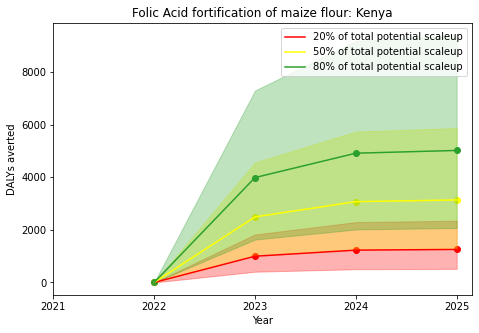

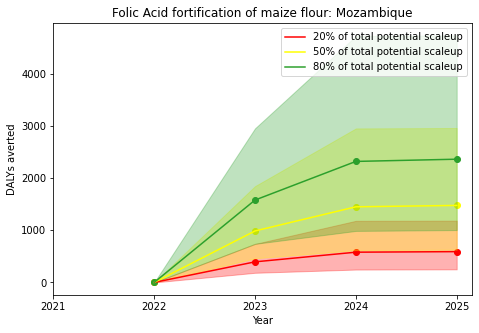

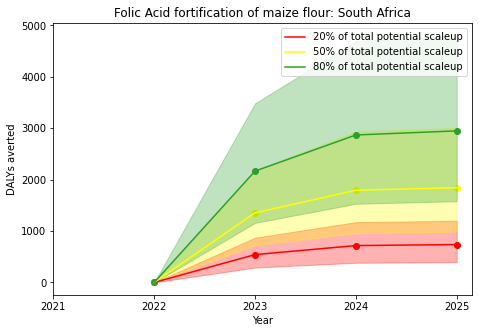

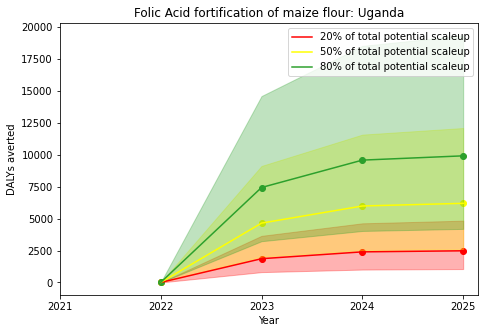

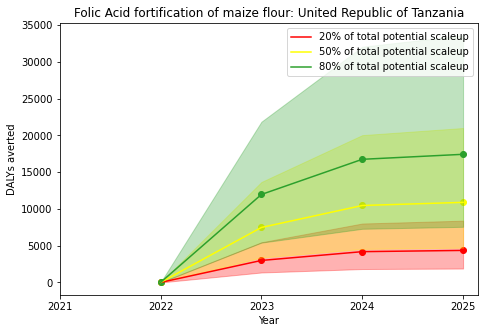

In [32]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


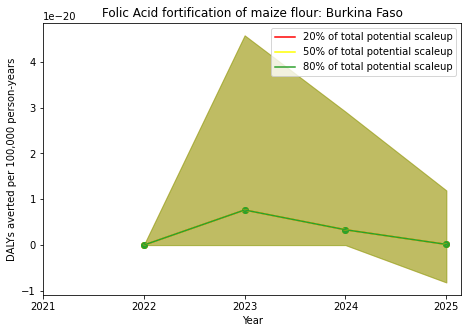

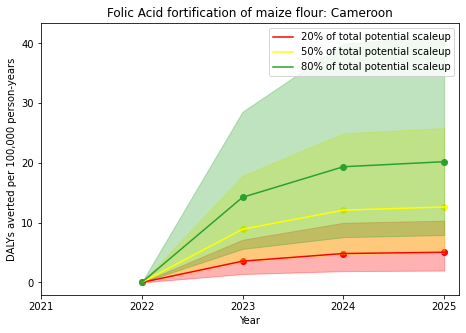

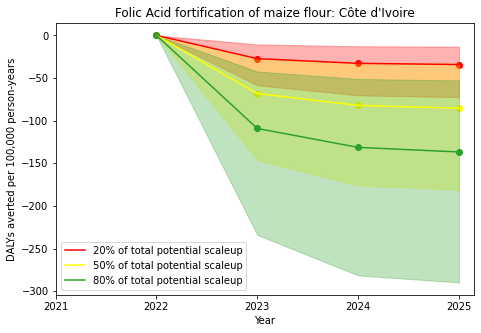

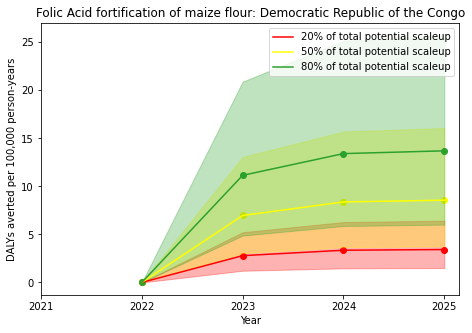

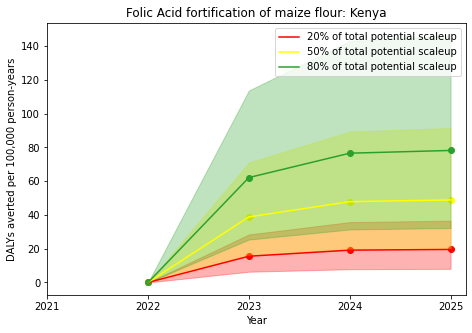

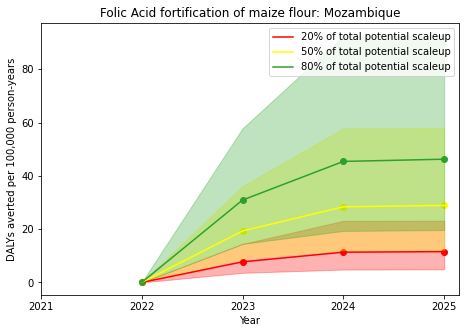

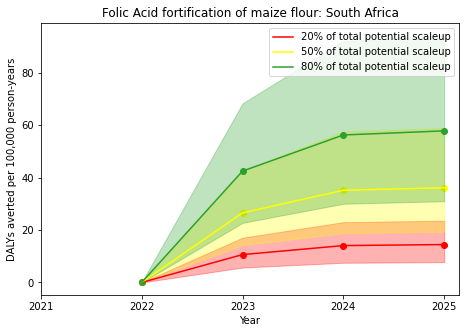

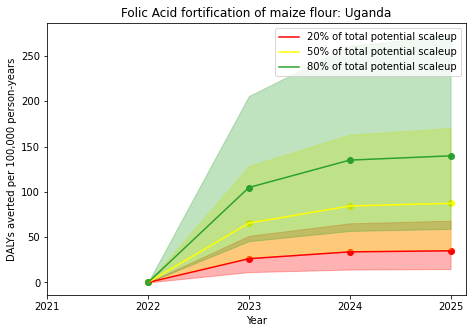

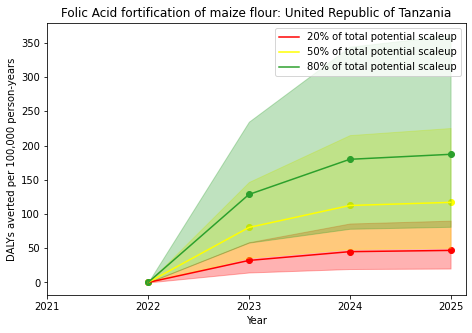

In [33]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


In [34]:
# def plot_dalys_averted(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]
            
#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)
    
#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
# plot_dalys_averted(save_path)


In [35]:
# def plot_dalys_averted_rate(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]

#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted per 100,000 person-years')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)

#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
# plot_dalys_averted_rate(save_path)

In [36]:
# this is why kenya is negative
inputs = pd.read_csv(input_data_path)

inputs[(inputs.location_name=="Kenya") & (inputs.nutrient=="folic acid")]



,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
99,180,Kenya,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000000,0.00000,0.000000
108,180,Kenya,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,34.703333,15.25348,54.153186


In [37]:
inputs[(inputs.location_name=="Kenya") & (inputs.vehicle.isin(['maize flour','wheat flour'])) & (inputs.value_description=="percent of population eating industrially produced vehicle")]

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile
98,180,Kenya,total population,maize flour,percent of population eating industrially prod...,na,36.67,17.221861,56.118139
107,180,Kenya,total population,wheat flour,percent of population eating industrially prod...,na,30.95,13.603743,48.296257
